In [45]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, LeaveOneOut
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression


#IMPORT TRAIN AND TEST SETS
train_features = pd.read_csv('./data/derived/feature_selection/pspline_training_data.csv', index_col=0)
test_features = pd.read_csv('./data/derived/feature_selection/pspline_test_data.csv', index_col=0)
combined = pd.concat([train_features, test_features])

In [46]:
features_derived = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'genome_ambig',
                    'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'gag_ambig',
                    'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 'pol_ambig',
                    'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp120_ambig',
                    'gp41_lrtt', 'gp41_maf12c', 'gp41_maf3c', 'gp41_tips', 'gp41_ambig'
]

In [47]:
# Convert TSI_days to TSI_years
train_features['TSI_years'] = train_features['TSI_days'] / 365
test_features['TSI_years'] = test_features['TSI_days'] / 365

# Transform TSI_years using the square root
train_features['sqrt_TSI_years'] = np.sqrt(train_features['TSI_years'])
test_features['sqrt_TSI_years'] = np.sqrt(test_features['TSI_years'])

# Transform TSI_years using the square root
train_features['log_TSI_years'] = np.log1p(train_features['TSI_years'])
test_features['log_TSI_years'] = np.log1p(test_features['TSI_years'])

In [48]:
# Convert TSI_days to TSI_years
combined['TSI_years'] = combined['TSI_days'] / 365

# Transform TSI_years using the square root
combined['log_TSI_years'] = np.log1p(combined['TSI_years'])

# Features and target variable for the combined dataset
X = combined[features_derived]
y = combined['log_TSI_years']

In [7]:
# Initialize LeaveOneOut cross-validator
loo = LeaveOneOut()

# Arrays to store results
predictions = []
true_values = []
prediction_errors = []

# Perform LOO-CV
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train Random Forest model
    model_log = RandomForestRegressor(n_estimators= 300, random_state=42,  
                                        bootstrap= True,
                                        max_depth= 10,
                                        max_features= 'sqrt',
                                        min_samples_leaf= 2,
                                        min_samples_split= 5,
                                        )
    model_log.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model_log.predict(X_test)
    
    # Store results
    predictions.append(y_pred[0])
    true_values.append(y_test.values[0])
    prediction_errors.append(np.abs(y_pred[0] - y_test.values[0]))


In [8]:
# Convert results to numpy arrays
predictions = np.array(predictions)
true_values = np.array(true_values)
prediction_errors = np.array(prediction_errors)

# Train a model on the mean absolute errors to generate prediction intervals
error_model = RandomForestRegressor(n_estimators= 300, random_state=42,   #log model 
                                    bootstrap= True,
                                    max_depth= 10,
                                    max_features= 'sqrt',
                                    min_samples_leaf= 2,
                                    min_samples_split= 5,
                                    )
error_model.fit(X, prediction_errors)

# Generate prediction intervals for the combined set
prediction_intervals = error_model.predict(X)



Mean Squared Error: 0.1823059318312075
Mean Aboslute Error: <function mean_absolute_error at 0x132229440>]
R-squared: 0.6188734717228728


In [10]:
# Evaluate the model on the combined set
mse = mean_squared_error(true_values, predictions)
mae = mean_absolute_error(true_values, predictions)
r2 = r2_score(true_values, predictions)

print(f"Mean Squared Error: {mse}")
print(f"Mean Aboslute Error: {mae}]")
print(f"R-squared: {r2}")

Mean Squared Error: 0.1823059318312075
Mean Aboslute Error: 0.3145405560968565]
R-squared: 0.6188734717228728


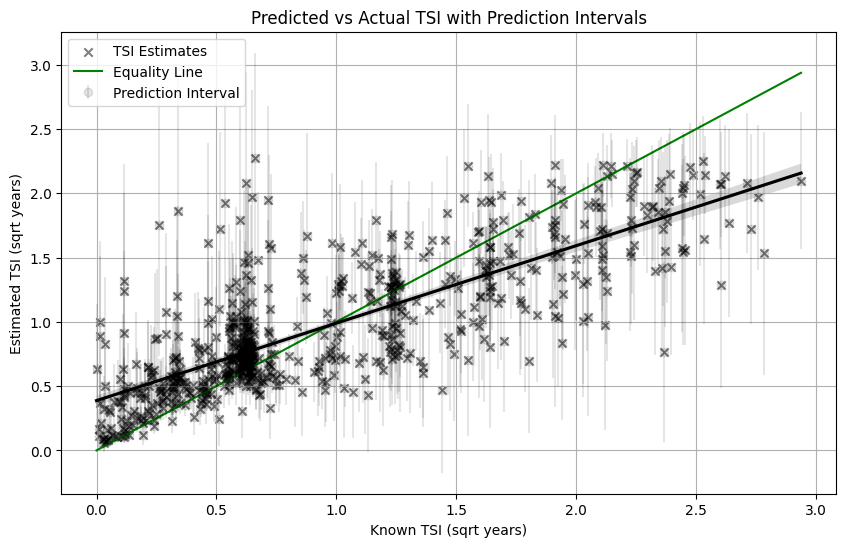

In [9]:
# Plot predicted vs actual values with prediction intervals
plt.figure(figsize=(10, 6))
plt.scatter(true_values, predictions, alpha=0.5, label='TSI Estimates', color='black', marker='x') #predictions vs true values 
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'g-', label='Equality Line') #equality line
sns.regplot(x=true_values, y=predictions, scatter=False, ci=95, color='black') #regression line
plt.errorbar(true_values, predictions, yerr=prediction_intervals, fmt='o', alpha=0.1, color='black', label='Prediction Interval')
plt.xlabel('Known TSI (sqrt years)')
plt.ylabel('Estimated TSI (sqrt years)')
plt.title('Predicted vs Actual TSI with Prediction Intervals')
plt.legend()
plt.grid(True) 
plt.show()

# FEATURE SET 13

## A - hyper parameter tuned

In [49]:
features13= ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'genome_ambig',
            'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'gag_ambig',
            'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_ambig',
            'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp120_ambig',
            'gp41_lrtt', 'gp41_maf12c', 'gp41_maf3c', 'gp41_tips', 'gp41_ambig',
            'lrtt_coeff_1', 'lrtt_coeff_3', 'lrtt_coeff_11']

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Features and target variable for training and testing sets
X_train = train_features[features13]
y_train = train_features['log_TSI_years']
X_test = test_features[features13]
y_test = test_features['log_TSI_years']

grid_search_f13 = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                                param_grid=param_grid, 
                                cv=3, n_jobs=-1)
grid_search_f13.fit(X_train, y_train)

best_model_f13 = grid_search_f13.best_estimator_

# Make predictions
y_pred_f13 = best_model_f13.predict(X_test)

In [50]:
# Evaluate the model
mse_f13 = mean_squared_error(y_test, y_pred_f13)
mae_f13 = mean_absolute_error(y_test, y_pred_f13)
rmse_f13 = root_mean_squared_error(y_test, y_pred_f13)
r2_f13 = r2_score(y_test, y_pred_f13)
print(f"Best Parameters: {grid_search_f13.best_params_}")
print(f"Mean Squared Error: {mse_f13}")
print(f"Mean Absolute Error: {mae_f13}")
print(f"Root Mean Squared Error: {rmse_f13}")
print(f"R-squared: {r2_f13}")
'''
for knots = 4 for maf3c 
Best Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Mean Squared Error: 0.1743753460221731
Mean Absolute Error: 0.3065167901857197
Root Mean Squared Error: 0.41758274152815883
R-squared: 0.6345165311076555
'''

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error: 0.17548484451051344
Mean Absolute Error: 0.3053082477586443
Root Mean Squared Error: 0.4189091124701317
R-squared: 0.6321910684462202


"\nfor knots = 4 for maf3c \nBest Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}\nMean Squared Error: 0.1743753460221731\nMean Absolute Error: 0.3065167901857197\nRoot Mean Squared Error: 0.41758274152815883\nR-squared: 0.6345165311076555\n"

## B - loocv

In [51]:
# Features and target variable for the combined dataset
X = combined[features13]
y = combined['log_TSI_years']

# Initialize LeaveOneOut cross-validator
loo = LeaveOneOut()

# Arrays to store results
predictions = []
true_values = []
prediction_errors = []

# Perform LOO-CV
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train Random Forest model
    model = RandomForestRegressor(n_estimators= 200, random_state=42,  
                                        bootstrap= True,
                                        max_depth= 20,
                                        max_features= 'log2',
                                        min_samples_leaf= 2,
                                        min_samples_split= 2,
                                        )
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Store results
    predictions.append(y_pred[0])
    true_values.append(y_test.values[0])
    prediction_errors.append(np.abs(y_pred[0] - y_test.values[0]))

# Convert results to numpy arrays
predictions = np.array(predictions)
true_values = np.array(true_values)
prediction_errors = np.array(prediction_errors)

# Train a model on the mean absolute errors to generate prediction intervals
error_model = RandomForestRegressor(n_estimators= 300, random_state=42,  
                                        bootstrap= True,
                                        max_depth= None,
                                        max_features= 'sqrt',
                                        min_samples_leaf= 2,
                                        min_samples_split= 5,
                                        )
error_model.fit(X, prediction_errors)

# Generate prediction intervals for the combined set
prediction_intervals = error_model.predict(X)

In [52]:
# Evaluate the model on the combined set
mse = mean_squared_error(true_values, predictions)
mae = mean_absolute_error(true_values, predictions)
rmse = root_mean_squared_error(true_values, predictions)
r2 = r2_score(true_values, predictions)

print(f"Mean Squared Error: {mse}")
print(f"Mean Aboslute Error: {mae}")
print(f"Root Mean Square Error: {rmse}")
print(f"R-squared: {r2}")

'''
Mean Squared Error: 0.17764224966491612
Mean Aboslute Error: 0.3111099048000167
Root Mean Square Error: 0.4214762741423485
R-squared: 0.6286233080291992
'''


Mean Squared Error: 0.1802673022679676
Mean Aboslute Error: 0.31322761910611274
Root Mean Square Error: 0.4245789705908285
R-squared: 0.6231354054958238


'\nMean Squared Error: 0.17764224966491612\nMean Aboslute Error: 0.3111099048000167\nRoot Mean Square Error: 0.4214762741423485\nR-squared: 0.6286233080291992\n'

## C - plot

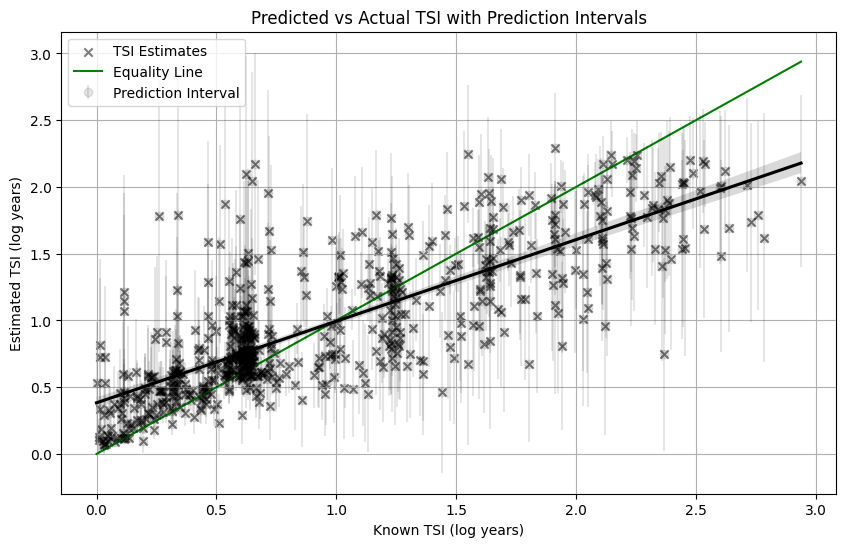

In [38]:
# Plot predicted vs actual values with prediction intervals
plt.figure(figsize=(10, 6))
plt.scatter(true_values, predictions, alpha=0.5, label='TSI Estimates', color='black', marker='x') #predictions vs true values 
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'g-', label='Equality Line') #equality line
sns.regplot(x=true_values, y=predictions, scatter=False, ci=95, color='black') #regression line
plt.errorbar(true_values, predictions, yerr=prediction_intervals, fmt='o', alpha=0.1, color='black', label='Prediction Interval')
plt.xlabel('Known TSI (log years)')
plt.ylabel('Estimated TSI (log years)')
plt.title('Predicted vs Actual TSI with Prediction Intervals')
plt.legend()
plt.grid(True) 
plt.show()

# FEATURE SET 12

## A - hyperparameter tuned

In [53]:
features12= ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'genome_ambig',
            'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'gag_ambig',
            'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 'pol_ambig',
            'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp120_ambig',
            'gp41_lrtt', 'gp41_maf12c', 'gp41_maf3c', 'gp41_tips', 'gp41_ambig',
            'lrtt_coeff_1', 'lrtt_coeff_3', 'lrtt_coeff_11']

# Features and target variable for training and testing sets
X_train = train_features[features12]
y_train = train_features['log_TSI_years']
X_test = test_features[features12]
y_test = test_features['log_TSI_years']

grid_search_f12 = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                                param_grid=param_grid, 
                                cv=3, n_jobs=-1)
grid_search_f12.fit(X_train, y_train)

best_model_f12 = grid_search_f12.best_estimator_

# Make predictions
y_pred_f12 = best_model_f12.predict(X_test)

In [54]:
# Evaluate the model
mse_f12 = mean_squared_error(y_test, y_pred_f12)
mae_f12 = mean_absolute_error(y_test, y_pred_f12)
rmse_f12 = root_mean_squared_error(y_test, y_pred_f12)
r2_f12 = r2_score(y_test, y_pred_f12)
print(f"Best Parameters: {grid_search_f12.best_params_}")
print(f"Mean Squared Error: {mse_f12}")
print(f"Mean Absolute Error: {mae_f12}")
print(f"Root Mean Squared Error: {rmse_f12}")
print(f"R-squared: {r2_f12}")

Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error: 0.17547689229435498
Mean Absolute Error: 0.30583958523102156
Root Mean Squared Error: 0.41889962078564236
R-squared: 0.6322077359603686


## B - LOOCV

In [57]:
# Features and target variable for the combined dataset
X = combined[features12]
y = combined['log_TSI_years']

# Initialize LeaveOneOut cross-validator
loo = LeaveOneOut()

# Arrays to store results
predictions = []
true_values = []
prediction_errors = []

# Perform LOO-CV
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train Random Forest model
    model = RandomForestRegressor(n_estimators= 100, random_state=42,  
                                        bootstrap= True,
                                        max_depth= 20,
                                        max_features= 'log2',
                                        min_samples_leaf= 2,
                                        min_samples_split= 2,
                                        )
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Store results
    predictions.append(y_pred[0])
    true_values.append(y_test.values[0])
    prediction_errors.append(np.abs(y_pred[0] - y_test.values[0]))

# Convert results to numpy arrays
predictions = np.array(predictions)
true_values = np.array(true_values)
prediction_errors = np.array(prediction_errors)

# Train a model on the mean absolute errors to generate prediction intervals
error_model = RandomForestRegressor(n_estimators= 300, random_state=42,  
                                        bootstrap= True,
                                        max_depth= None,
                                        max_features= 'sqrt',
                                        min_samples_leaf= 2,
                                        min_samples_split= 5,
                                        )
error_model.fit(X, prediction_errors)

# Generate prediction intervals for the combined set
prediction_intervals = error_model.predict(X)

In [58]:
# Evaluate the model on the combined set
mse = mean_squared_error(true_values, predictions)
mae = mean_absolute_error(true_values, predictions)
rmse = root_mean_squared_error(true_values, predictions)
r2 = r2_score(true_values, predictions)

print(f"Mean Squared Error: {mse}")
print(f"Mean Aboslute Error: {mae}")
print(f"Root Mean Square Error: {rmse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.17997618403080556
Mean Aboslute Error: 0.3138042589566376
Root Mean Square Error: 0.42423600039459824
R-squared: 0.6237440136849992
